## 1. 데이터 로드

In [1]:

# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rc('font', family='Malgun Gothic')  # 한글 폰트 설정



In [2]:
# 1. 데이터 로드
train = pd.read_csv("train.csv")   # 대회 제공 학습 데이터
test = pd.read_csv("test.csv")     # 대회 제공 테스트 데이터
sample_submission = pd.read_csv("sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.info())

Train shape: (26457, 20)
Test shape: (10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  f

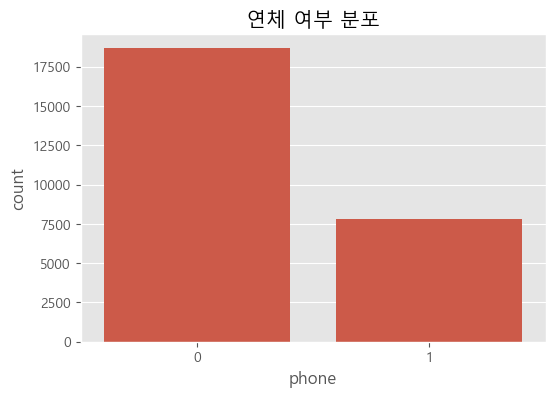

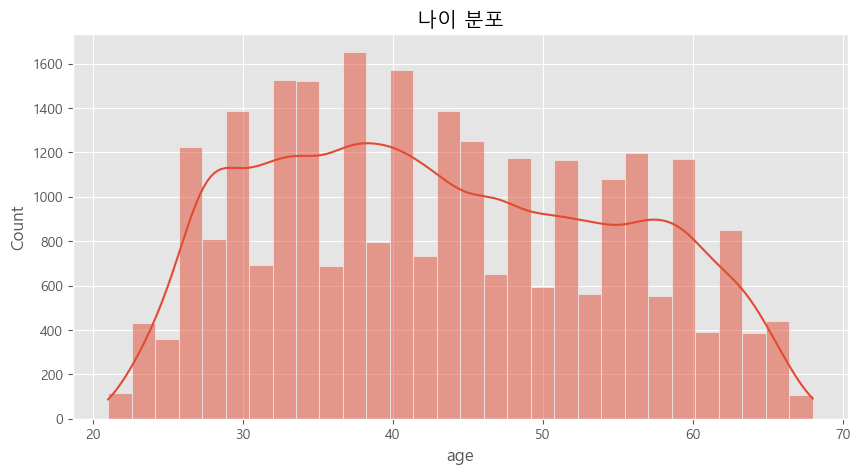

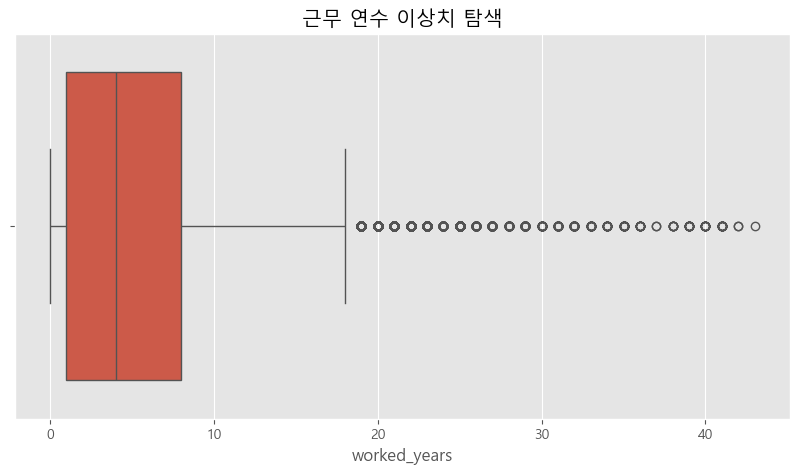

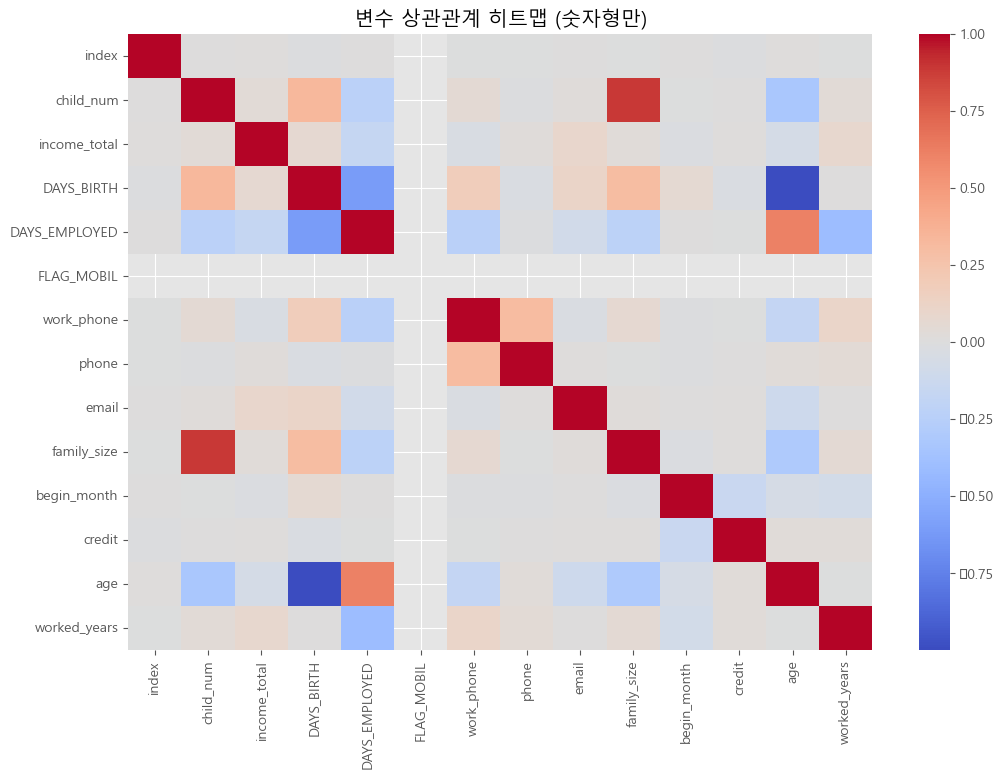

In [3]:
# 2. EDA (탐색적 데이터 분석)
# (1) 연체 여부 분포
plt.figure(figsize=(6,4))
sns.countplot(x='phone', data=train)
plt.title("연체 여부 분포")
plt.show()

# (2) 나이 분포
train['age'] = abs(train['DAYS_BIRTH']) // 365
plt.figure(figsize=(10,5))
sns.histplot(train['age'], bins=30, kde=True)
plt.title("나이 분포")
plt.show()

# (3) 근무 연수 박스플롯
train['worked_years'] = train['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else abs(x)//365)
plt.figure(figsize=(10,5))
sns.boxplot(x=train['worked_years'])
plt.title("근무 연수 이상치 탐색")
plt.show()

# (4) 상관관계 히트맵 (숫자형 변수만 선택)
plt.figure(figsize=(12,8))
sns.heatmap(train.select_dtypes(include=['int64','float64']).corr(), annot=False, cmap="coolwarm")
plt.title("변수 상관관계 히트맵 (숫자형만)")
plt.show()

In [4]:
# 3. 데이터 전처리 함수
def preprocess(df):
    df = df.copy()
    
    # 결측치 처리
    if 'occyp_type' in df.columns:
        df['occyp_type'] = df['occyp_type'].fillna('None')
    
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # 파생 변수 생성
    if 'DAYS_BIRTH' in df.columns:
        df['age'] = abs(df['DAYS_BIRTH']) // 365
    if 'DAYS_EMPLOYED' in df.columns:
        df['worked_years'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else abs(x)//365)
    if 'begin_month' in df.columns:
        df['months_issued'] = abs(df['begin_month'])
    
    # 불필요한 컬럼 제거
    drop_cols = ['index','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    
    # 범주형 인코딩
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    return df


In [5]:
# 4. 전처리 적용
train_prep = preprocess(train)
test_prep = preprocess(test)



In [6]:
# 5. 모델링 준비
X = train_prep.drop(columns=['credit'])   # 학습 데이터에서 타깃 제거
y = train_prep['credit']                  # 타깃 변수

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# test_prep에는 'credit' 컬럼이 없으므로 drop 불필요
test_scaled = scaler.transform(test_prep)

# 학습/검증 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 학습
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# 성능 확인
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))




              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       650
         1.0       0.33      0.00      0.00      1262
         2.0       0.64      1.00      0.78      3380

    accuracy                           0.64      5292
   macro avg       0.32      0.33      0.26      5292
weighted avg       0.49      0.64      0.50      5292



In [7]:
# 6. 모델 학습 (로지스틱 회귀 예시)
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# 검증 성능 확인
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))



              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       650
         1.0       0.33      0.00      0.00      1262
         2.0       0.64      1.00      0.78      3380

    accuracy                           0.64      5292
   macro avg       0.32      0.33      0.26      5292
weighted avg       0.49      0.64      0.50      5292



## 4. 최종 예측 및 제출 파일 생성

In [8]:
# 7. 제출 파일 생성
test_pred = model.predict(test_scaled)
submission = sample_submission.copy()
submission['target'] = test_pred

submission.to_csv("submission.csv", index=False)
print("✅ 제출용 CSV 파일 생성 완료: submission.csv")


✅ 제출용 CSV 파일 생성 완료: submission.csv
